In [13]:
#!pip install torch torchvision timm

In [ ]:
#!pip install transformers

In [37]:
#!pip install torchshow

## Import all realated packages

In [20]:
import os
import sys
import time
import math
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms

from scipy.stats import gaussian_kde

In [45]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tv_transforms
import timm

In [22]:
plt.style.use('ggplot')
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

## Define Distance Correlation

In [23]:
class Loss_DC(nn.Module):
    def __init__(self):
        super(Loss_DC, self).__init__()


    def Distance_Correlation(self, latent, control):
        matrix_a = torch.sqrt(torch.sum(torch.square(latent.unsqueeze(0) - latent.unsqueeze(1)), dim = -1) + 1e-12)
        matrix_b = torch.sqrt(torch.sum(torch.square(control.unsqueeze(0) - control.unsqueeze(1)), dim = -1) + 1e-12)

        matrix_A = matrix_a - torch.mean(matrix_a, dim = 0, keepdims= True) - torch.mean(matrix_a, dim = 1, keepdims= True) + torch.mean(matrix_a)
        matrix_B = matrix_b - torch.mean(matrix_b, dim = 0, keepdims= True) - torch.mean(matrix_b, dim = 1, keepdims= True) + torch.mean(matrix_b)

        Gamma_XY = torch.sum(matrix_A * matrix_B)/ (matrix_A.shape[0] * matrix_A.shape[1])
        Gamma_XX = torch.sum(matrix_A * matrix_A)/ (matrix_A.shape[0] * matrix_A.shape[1])
        Gamma_YY = torch.sum(matrix_B * matrix_B)/ (matrix_A.shape[0] * matrix_A.shape[1])

        correlation_r = Gamma_XY/torch.sqrt(Gamma_XX * Gamma_YY + 1e-9)
        return correlation_r


    def forward(self, latent, control):
        dc_loss = self.Distance_Correlation(latent, control)

        return dc_loss

## Pearson Corrletaion vs Distance Correlation
This demo shows that Distance Correlation is better compared with Pearson Correlation

In [24]:
def Peasor_Correlation(latent, control):
    batch_size = latent.shape[0]

    up = (latent - torch.mean(latent, dim = 0, keepdims= True) ) * (control - torch.mean(control, dim = 0, keepdims= True) )
    up = torch.sum(up) / batch_size

    down = torch.sum((latent - torch.mean(latent, dim = 0, keepdims= True) ) ** 2 ) * torch.sum((control - torch.mean(control, dim = 0, keepdims= True) ) ** 2)
    down = down / (batch_size ** 2)

    return up/torch.sqrt(down)

Here, we will use a special case to obtain the eigenvalues of these two-dimensional datasets.
Then, calculate the standard deviation of x and y from the square root of the variance and multiplaying with the given number of standard deviations.

In [25]:
def confidence_ellipse(x, y, ax, n_std=2.9, facecolor='none', cov=None, **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, lw=3, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

Now we compare Pearson Correlation and Distance Correlation.

Pearson Correration: -0.004998477641493082
Distance Correlation: 0.2065926492214203


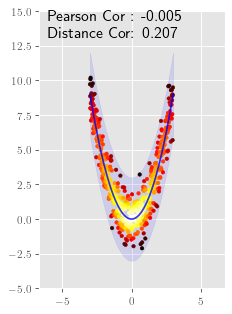

In [46]:
batch_size=10000
Distance_Correlation = Loss_DC()
x = np.linspace(-3, 3, num=batch_size)
y = np.random.randn(batch_size)

y = y + x**2

x = torch.Tensor(x)
x = x.reshape([batch_size,-1])
y = torch.Tensor(y)
y = y.reshape([batch_size,-1])

pc = Peasor_Correlation(x,y)
dc = Distance_Correlation(x,y)
print(f'Pearson Correration: {pc}')
print(f'Distance Correlation: {dc}')

outR = torch.cat([x,y], axis=-1).numpy()

z = gaussian_kde(outR.transpose())(outR.transpose())
figure(figsize=(3, 4.5), dpi=80)
new_X = np.linspace(-3, 3, num=batch_size)
new_Y_low = new_X**2 - 3
new_Y_high = new_X**2 + 3
plt.plot(new_X, new_X**2, 'b-', alpha=0.8)
ax = plt.gca()
ax.fill_between(new_X, new_Y_low, new_Y_high, color='b' , alpha=0.1)
plt.scatter(x=x[::20], y = y[::20],c=z[::20],s=10,cmap='hot')
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 15))
# ax.set_title(r'$y=x^2+n,n\sim \mathcal{N}(0,1)$'))
plt.text(0.05, 0.95, 'Pearson Cor : {:0.3f}\nDistance Cor: {:0.3f}'.format(pc, dc) , horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, size='x-large')
plt.savefig('pearson_distance1.png', dpi=300)
plt.show()

Pearson Correration: 0.6723114848136902
Distance Correlation: 0.38851210474967957


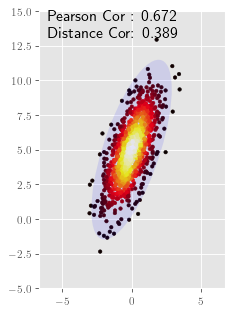

In [47]:
xy = np.random.multivariate_normal(mean=np.asarray([0,5]), cov = np.asarray([[1,1.5],[1.5,5]]), size=batch_size)
x = xy[:,0]
y = xy[:,1]

x = torch.Tensor(x)
x = x.reshape([batch_size,-1])
y = torch.Tensor(y)
y = y.reshape([batch_size,-1])

pc = Peasor_Correlation(x,y)
dc = Distance_Correlation(x,y)
print(f'Pearson Correration: {pc}')
print(f'Distance Correlation: {dc}')

outR = torch.cat([x,y], axis=-1).numpy()
z = gaussian_kde(outR.transpose())(outR.transpose())

figure(figsize=(3, 4.5), dpi=80)
plt.scatter(x=x[::10], y = y[::10],c=z[::10],s=10,cmap='hot')
ax = plt.gca()
confidence_ellipse(outR[:,0], outR[:,1],ax, cov=np.asarray([[1,1.5],[1.5,5]]), edgecolor=None, facecolor='blue', alpha=0.1)
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 15))
plt.text(0.05, 0.95, 'Pearson Cor : {:0.3f}\nDistance Cor: {:0.3f}'.format(pc, dc) , horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, size='x-large')
plt.savefig('pearson_distance2.png', dpi=300)
plt.show()

Pearson Correration: 0.005108433775603771
Distance Correlation: 0.0001825056242523715


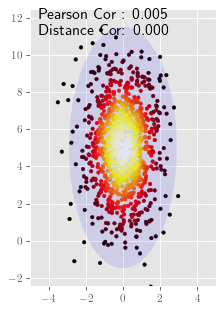

In [48]:
xy = np.random.multivariate_normal(mean=np.asarray([0,5]), cov = np.asarray([[1,0],[0,5]]), size=batch_size)
x = xy[:,0]
y = xy[:,1]

x = torch.Tensor(x)
x = x.reshape([batch_size,-1])
y = torch.Tensor(y)
y = y.reshape([batch_size,-1])

pc = Peasor_Correlation(x,y)
dc = Distance_Correlation(x,y)
print(f'Pearson Correration: {pc}')
print(f'Distance Correlation: {dc}')

outR = torch.cat([x,y], axis=-1).numpy()
z = gaussian_kde(outR.transpose())(outR.transpose())

figure(figsize=(3, 4.5), dpi=80)
plt.scatter(x=x[::10], y = y[::10],c=z[::10],s=10,cmap='hot')
ax = plt.gca()
confidence_ellipse(outR[:,0], outR[:,1],ax, cov=np.asarray([[1,0],[0,5]]), edgecolor=None, facecolor='blue', alpha=0.1)
ax.axis('equal')
ax.set(xlim=(-5, 5), ylim=(-5, 15))
plt.text(0.05, 0.95, 'Pearson Cor : {:0.3f}\nDistance Cor: {:0.3f}'.format(pc.abs(), dc) , horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, size='x-large')
plt.savefig('pearson_distance3.png', dpi=300)
plt.show()

## Define Models
We only use the features to evaluate the similarity between networks

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform_train = tv_transforms.Compose([
    tv_transforms.RandomCrop(32, padding=4),
    tv_transforms.RandomHorizontalFlip(),
    tv_transforms.ToTensor(),
    tv_transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = tv_transforms.Compose([
    tv_transforms.ToTensor(),
    tv_transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [32]:
model1 = timm.create_model('resnet18', pretrained=True)
model2 = timm.create_model('resnet50', pretrained=True)
model1, model2 = model1.to(device), model2.to(device)

model1.eval()
model2.eval()

In [10]:
similarity = Loss_DC()

sim = 0

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        features1 = model1.forward_features(inputs)
        features2 = model2.forward_features(inputs)

        features1 = features1.view([features1.shape[0], -1])
        features2 = features2.view([features2.shape[0], -1])
        
        sim += similarity(features1, features2).detach()

print(sim/len(trainloader))

Files already downloaded and verified
Files already downloaded and verified
tensor(0.6791)


## A simple example for partial distance correlation

In [36]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embed_model = BertModel.from_pretrained("bert-base-uncased")
embed_model.eval()

class_embedding = []
for cifar_class in classes:
    encoded_input = tokenizer(cifar_class.lower(), return_tensors='pt')
    output = embed_model(**encoded_input)
    class_embedding.append(output[1])
class_embedding = torch.cat(class_embedding).to(device)
print(class_embedding)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.7786, -0.1859,  0.5463,  ...,  0.4157, -0.5557,  0.7506],
        [-0.7872, -0.1686,  0.2455,  ...,  0.2083, -0.5253,  0.8364],
        [-0.8581, -0.2902,  0.3572,  ...,  0.2868, -0.6016,  0.8708],
        ...,
        [-0.8625, -0.3620, -0.0616,  ...,  0.2378, -0.6112,  0.8878],
        [-0.7298, -0.1935,  0.5247,  ...,  0.4959, -0.5106,  0.7271],
        [-0.8218, -0.1641,  0.2925,  ...,  0.3272, -0.5407,  0.8550]],
       grad_fn=<CatBackward0>)


## Definition of the Partial Distance Correlation

In [ ]:
def P_Distance_Matrix(latent):
    n = latent.shape[0]
    matrix_a = torch.sqrt(torch.sum(torch.square(latent.unsqueeze(0) - latent.unsqueeze(1)), dim = -1)  + 1e-18)
    matrix_A = matrix_a - torch.sum(matrix_a, dim = 0, keepdims= True)/(n-2) - torch.sum(matrix_a, dim = 1, keepdims= True)/(n-2) \
                + torch.sum(matrix_a)/((n-1)*(n-2))

    diag_A = torch.diag(torch.diag(matrix_A) ) 
    matrix_A = matrix_A - diag_A
    return matrix_A


def bracket_op(matrix_A, matrix_B):
    n = matrix_A.shape[0]
    return torch.sum(matrix_A * matrix_B)/(n*(n-3))


def P_removal(matrix_A, matrix_C):
    result = matrix_A - bracket_op(matrix_A, matrix_C) / bracket_op(matrix_C, matrix_C) * matrix_C
    return result

def Correlation(matrix_A, matrix_B):
    Gamma_XY = bracket_op(matrix_A, matrix_B)
    Gamma_XX = bracket_op(matrix_A, matrix_A)
    Gamma_YY = bracket_op(matrix_B, matrix_B)

    correlation_r = Gamma_XY/torch.sqrt(Gamma_XX * Gamma_YY + 1e-18)

    return correlation_r


def P_DC(latent_A, latent_B, ground_truth):
    matrix_A = P_Distance_Matrix(latent_A)
    matrix_B = P_Distance_Matrix(latent_B)
    matrix_GT = P_Distance_Matrix(ground_truth)

    matrix_A_B = P_removal(matrix_A, matrix_B)

    cr = Correlation(matrix_A_B, matrix_GT)

    return cr


def New_DC(latent_A, ground_truth):
    matrix_A = P_Distance_Matrix(latent_A)
    matrix_GT = P_Distance_Matrix(ground_truth)
    cr = Correlation(matrix_A, matrix_GT)

    return cr

We will remove model 2 from model 1 and measure the information remaining

In [18]:
total_pdc = 0
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        features1 = model1.forward_features(inputs)
        features2 = model2.forward_features(inputs)

        features1 = features1.view([features1.shape[0], -1])
        features2 = features2.view([features2.shape[0], -1])

        ground_truth = class_embedding[targets]
        
        pdcor = P_DC(features1, features2, ground_truth)
        
        total_pdc += pdcor.detach()

print(total_pdc/len(trainloader))

KeyboardInterrupt: 